# **EMI, Stance, Ideology**

In [1]:
scores = "non_clipped"

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
 
from scipy.stats import ttest_ind
from scipy.stats import pearsonr, norm
import pingouin as pg
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as mcolors

In [3]:
def get_counts_and_shares(df, column):
    return df[column].value_counts().to_frame('Count').join(df[column].value_counts(normalize=True).to_frame('%')).reset_index()


## **Data**

In [4]:
# import EMI data
df_all = pd.read_csv(f"../../data/analysis_data/df_all_{scores}.csv")

# rename
df_all = df_all.rename(columns = {"predictions_prob_disagree" : 'prob_disagree'})
df_all

/tmp/ipykernel_327/3018109309.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(f"../../data/analysis_data/df_all_{scores}.csv")


,msg_id_parent,msg_id_child,submission_id,subreddit,exact_time_child,author_child,author_parent,author_submission,finetuned_child_E_norm,finetuned_child_I_norm,...,finetuned_parent_len_norm_z_trans_EMI,finetuned_child_len_norm_z_trans_EMI,finetuned_submission_len_norm_z_trans_EMI,self_parent_len_norm_z_trans_EMI,self_child_len_norm_z_trans_EMI,self_submission_len_norm_z_trans_EMI,predictions_label_ft,predictions_score_ft,prob_disagree,predictions_ft
0,c7ecp8d,c7ecs2n,14m325,Ask_Politics,1355166551.0,karmanaut,Ramblin_Dash,karmanaut,0.053025,0.072843,...,0.514532,-0.116730,0.594431,0.624110,-0.011457,0.172262,0,0.6180,0.38180,no_disagreement
1,c7ecp8d,c7ecxpk,14m325,Ask_Politics,1355167049.0,zoolander951,Ramblin_Dash,karmanaut,0.040605,0.001874,...,0.514532,0.363800,0.594431,0.624110,0.012864,0.172262,0,0.7134,0.28640,no_disagreement
2,c7ecp8d,c7eflag,14m325,Ask_Politics,1355175187.0,zossima,Ramblin_Dash,karmanaut,0.037034,-0.026841,...,0.514532,0.571814,0.594431,0.624110,0.600814,0.172262,0,0.6580,0.34180,no_disagreement
3,c7efx8q,c7ejh1d,14m325,Ask_Politics,1355187644.0,fathermocker,senatorskeletor,karmanaut,0.046751,0.040446,...,0.269966,0.096978,0.594431,0.130100,0.070296,0.172262,1,0.9507,0.95070,disagree
4,c7efx8q,c7f8140,14m325,Ask_Politics,1355286254.0,PKMKII,senatorskeletor,karmanaut,0.029991,-0.043360,...,0.269966,0.644853,0.594431,0.130100,0.612353,0.172262,0,0.8580,0.14180,no_disagreement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4938799,kfkh5ib,kfmd52k,18uirzt,politics,1970-01-01 00:00:01.703977996,Knightforlife,freddiethebaer,optimalg,0.289315,0.222072,...,1.250681,0.671616,-0.580210,1.062374,0.498045,-0.857240,0,0.9550,0.04495,no_disagreement
4938800,kfklsb6,kforzbx,18uirzt,politics,1970-01-01 00:00:01.704023024,bakerfredricka,4blockhead,optimalg,0.192579,0.210383,...,1.367783,-0.043416,-0.580210,1.165189,-0.381238,-0.857240,0,0.9920,0.00774,no_disagreement
4938801,kfmq5kr,kfp6tzv,18uirzt,politics,1970-01-01 00:00:01.704032059,glassjar1,DoubleTFan,optimalg,0.078374,0.101258,...,-0.197753,-0.140261,-0.580210,0.242695,-0.122822,-0.857240,1,0.8500,0.85000,disagree
4938802,kfp3d4v,kfp8xh8,18uirzt,politics,1970-01-01 00:00:01.704033069,HaulinBoats,4blockhead,optimalg,0.137089,0.224533,...,0.600514,-0.617072,-0.580210,0.207855,-0.789836,-0.857240,0,0.9414,0.05875,no_disagreement


In [5]:
# all, incl mods
interactions_all = pd.read_csv(f"../../data/analysis_data/interactions_ideology_{scores}.csv")
interactions_all = interactions_all.merge(df_all[['msg_id_child', 'prob_disagree']], how = "left", right_on = "msg_id_child", left_on = "msg_id_child")
interactions_all = interactions_all.rename(columns = {"predictions_label_ft" :'disagreement_label'}) 

# mods only
mod_interactions = interactions_all[interactions_all["author_submission"].isin(["politicsmoderatorbot", "politicsmod", "automoderator"])]
mod_interactions = mod_interactions.rename(columns = {"predictions_label_ft" :'disagreement_label'}) 

# human only
interactions = pd.read_csv(f"../../data/analysis_data/full_interactions_ideology_{scores}.csv")
interactions = interactions.merge(df_all[['msg_id_child', 'prob_disagree']], how = "left", right_on = "msg_id_child", left_on = "msg_id_child")
interactions = interactions.rename(columns = {"predictions_label_ft" :'disagreement_label'}) 


/tmp/ipykernel_327/3613828893.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactions_all = pd.read_csv(f"../../data/analysis_data/interactions_ideology_{scores}.csv")
/tmp/ipykernel_327/3613828893.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactions = pd.read_csv(f"../../data/analysis_data/full_interactions_ideology_{scores}.csv")


## **Grouping Variables**

In [6]:
# Ideology labels
def ideology_category(row):
    p = row['parent_partisan']
    c = row['child_partisan']
    if p > 0 and c > 0:
        return 'CR & RR'
    elif p > 0 and c < 0:
        return 'CR & RL'
    elif p < 0 and c > 0:
        return 'CL & RR'
    elif p < 0 and c < 0:
        return 'CL & RL'
    else:
        return 'Mixed/Neutral'

# EMI labels
def emi_category(row):
    p = row['finetuned_parent_len_EMI_z_trans']
    c = row['finetuned_child_len_EMI_z_trans']
    if p > 0 and c > 0:
        return 'CE & RE'
    elif p > 0 and c < 0:
        return 'CE & RI'
    elif p < 0 and c > 0:
        return 'CI & RE'
    elif p < 0 and c < 0:
        return 'CI & RI'
    else:
        return 'Mixed/Neutral'


interactions['ideology_group'] = interactions.apply(ideology_category, axis=1)
interactions['emi_group'] = interactions.apply(emi_category, axis=1)

mod_interactions['ideology_group'] = mod_interactions.apply(ideology_category, axis=1)
mod_interactions['emi_group'] = mod_interactions.apply(emi_category, axis=1)

interactions_all['ideology_group'] = interactions_all.apply(ideology_category, axis=1)
interactions_all['emi_group'] = interactions_all.apply(emi_category, axis=1)


In [7]:

same_speaking = ['CE & RE', 'CI & RI']
same_ideology = ['CL & RL', 'CR & RR']
different_speaking = ['CE & RI', 'CI & RE']
different_ideology = ['CR & RL', 'CL & RR']


# Add a new column to label alignment
interactions['emi_alignment'] = interactions['emi_group'].apply(
    lambda x: 'Same' if x in same_speaking else 'Different')
mod_interactions['emi_alignment'] = mod_interactions['emi_group'].apply(
    lambda x: 'Same' if x in same_speaking else 'Different')
interactions_all['emi_alignment'] = interactions_all['emi_group'].apply(
    lambda x: 'Same' if x in same_speaking else 'Different')

interactions['ideology_alignment'] = interactions['ideology_group'].apply(
    lambda x: 'Same' if x in same_ideology else 'Different')
mod_interactions['ideology_alignment'] = mod_interactions['ideology_group'].apply(
    lambda x: 'Same' if x in same_ideology else 'Different')
interactions_all['ideology_alignment'] = interactions_all['ideology_group'].apply(
    lambda x: 'Same' if x in same_ideology else 'Different')

## **Disagreement Shares by the EMI alignment**

In [8]:
print("Humans")
print("------")
print(get_counts_and_shares(interactions, "predictions_ft"))

print("\n Mods")
print("------")
print(get_counts_and_shares(mod_interactions, "predictions_ft"))

print("\n All")
print("------")
print(get_counts_and_shares(interactions_all, "predictions_ft"))

Humans
------
    predictions_ft    Count        %
0  no_disagreement  1082700  0.66529
1         disagree   544711  0.33471

 Mods
------
    predictions_ft    Count         %
0  no_disagreement  2528422  0.765738
1         disagree   773519  0.234262

 All
------
    predictions_ft    Count         %
0  no_disagreement  3613331  0.732355
1         disagree  1320524  0.267645


In [9]:
# Humans
alignment_summary = (
    interactions
    .groupby('emi_alignment')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)

total_interactions = interactions.shape[0]
alignment_summary['interaction_share'] = alignment_summary['count'] / total_interactions
alignment_summary = alignment_summary.sort_values('disagreement_share', ascending=False)
alignment_summary = alignment_summary.sort_values('disagreement_share', ascending=False)


# Mods
alignment_summary_mods = (
    mod_interactions
    .groupby('emi_alignment')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)

total_interactions = mod_interactions.shape[0]
alignment_summary_mods['interaction_share'] = alignment_summary_mods['count'] / total_interactions
alignment_summary_mods = alignment_summary_mods.sort_values('disagreement_share', ascending=False)
alignment_summary_mods = alignment_summary_mods.sort_values('disagreement_share', ascending=False)

# All
alignment_summary_all = (
    interactions_all
    .groupby('emi_alignment')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)

total_interactions = interactions_all.shape[0]
alignment_summary_all['interaction_share'] = alignment_summary_all['count'] / total_interactions
alignment_summary_all = alignment_summary_all.sort_values('disagreement_share', ascending=False)
alignment_summary_all = alignment_summary_all.sort_values('disagreement_share', ascending=False)


print("Humans")
print("------")
print(alignment_summary)

print("\n Mods")
print("------")
print(alignment_summary_mods)

print("\n All")
print("------")
print(alignment_summary_all)

Humans
------
  emi_alignment  disagreement_share    count  interaction_share
1          Same            0.347154  1057510           0.649811
0     Different            0.311619   569901           0.350189

 Mods
------
  emi_alignment  disagreement_share    count  interaction_share
1          Same            0.241630  2053316           0.621851
0     Different            0.222146  1248625           0.378149

 All
------
  emi_alignment  disagreement_share    count  interaction_share
1          Same            0.277743  3113902            0.63113
0     Different            0.250370  1819953            0.36887


In [10]:
emi_summary_humans = (
    interactions
    .groupby('emi_group')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)
total_interactions = interactions.shape[0]
emi_summary_humans['interaction_share'] = emi_summary_humans['count'] / total_interactions
emi_summary_humans = emi_summary_humans.sort_values('disagreement_share', ascending=False)
emi_summary_humans = emi_summary_humans[emi_summary_humans["emi_group"] != "Mixed/Neutral"]



emi_summary_mods= (
    mod_interactions
    .groupby('emi_group')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)
total_interactions = mod_interactions.shape[0]
emi_summary_mods['interaction_share'] = emi_summary_mods['count'] / total_interactions
emi_summary_mods = emi_summary_mods.sort_values('disagreement_share', ascending=False)
emi_summary_mods = emi_summary_mods[emi_summary_mods["emi_group"] != "Mixed/Neutral"]

emi_summary_all = (
    interactions_all
    .groupby('emi_group')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)
total_interactions = interactions_all.shape[0]
emi_summary_all['interaction_share'] = emi_summary_all['count'] / total_interactions
emi_summary_all = emi_summary_all.sort_values('disagreement_share', ascending=False)
emi_summary_all = emi_summary_all[emi_summary_all["emi_group"] != "Mixed/Neutral"]


print("Humans")
print("------")
print(emi_summary_humans)

print("\n Mods")
print("------")
print(emi_summary_mods)

print("\n All")
print("------")
print(emi_summary_all)

Humans
------
  emi_group  disagreement_share   count  interaction_share
3   CI & RI            0.359970  579957           0.356368
0   CE & RE            0.331590  477553           0.293443
2   CI & RE            0.322186  291769           0.179284
1   CE & RI            0.300562  278069           0.170866

 Mods
------
  emi_group  disagreement_share    count  interaction_share
3   CI & RI            0.281036  1055254           0.319586
2   CI & RE            0.230231   622679           0.188580
1   CE & RI            0.214121   625782           0.189519
0   CE & RE            0.199966   998062           0.302265

 All
------
  emi_group  disagreement_share    count  interaction_share
3   CI & RI            0.309206  1636623           0.331713
2   CI & RE            0.259761   915152           0.185484
0   CE & RE            0.242886  1477279           0.299417
1   CE & RI            0.240892   904574           0.183340


## **Bar Plots**

In [11]:
emi_summary_humans.rename(columns = {"disagreement_share" : "dis_share_humans"}, inplace = True)
emi_summary_mods.rename(columns = {"disagreement_share" : "dis_share_mods"}, inplace = True)
emi_summary_all.rename(columns = {"disagreement_share" : "dis_share_all"}, inplace = True)

# merge all three
emi_summary_plot = emi_summary_mods[["emi_group", "dis_share_mods"]].merge(emi_summary_all[["emi_group", "dis_share_all", "interaction_share"]], 
                                            on = "emi_group").merge(emi_summary_humans[["emi_group", "dis_share_humans"]], on = "emi_group")

emi_summary_plot = pd.melt(emi_summary_plot, id_vars='emi_group', value_vars=['dis_share_mods', 'dis_share_all', 'dis_share_humans'])

emi_summary_plot = emi_summary_plot[emi_summary_plot["emi_group"] != "Mixed/Neutral"].reset_index(drop=True)
emi_summary_plot

,emi_group,variable,value
0,CI & RI,dis_share_mods,0.281036
1,CI & RE,dis_share_mods,0.230231
2,CE & RI,dis_share_mods,0.214121
3,CE & RE,dis_share_mods,0.199966
4,CI & RI,dis_share_all,0.309206
5,CI & RE,dis_share_all,0.259761
6,CE & RI,dis_share_all,0.240892
7,CE & RE,dis_share_all,0.242886
8,CI & RI,dis_share_humans,0.359970
9,CI & RE,dis_share_humans,0.322186


/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  

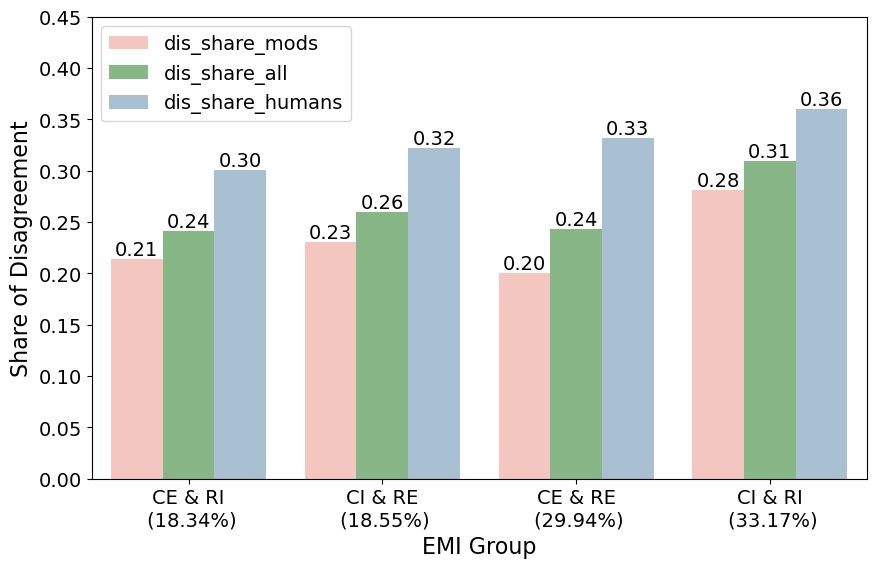

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the size here

xtick_label_map = {
    "CE & RE": "CE & RE\n (29.94%)",
    "CI & RI": "CI & RI\n (33.17%)",
    "CE & RI": "CE & RI\n (18.34%)",
    "CI & RE": "CI & RE\n (18.55%)"
}

color_dict = {"dis_share_mods": "salmon",
             "dis_share_humans" : "steelblue",
             "dis_share_all" : "green"}

sorted_order = (
    emi_summary_plot[emi_summary_plot["variable"] == "dis_share_humans"]
    .sort_values("value")["emi_group"]
    .tolist()
) 

# Create barplot
sns.barplot(
    data=emi_summary_plot,
    x="emi_group",
    y="value",
    hue="variable",
    palette=color_dict,
    alpha=0.5,
    order=sorted_order,
    errorbar="sd",
    ax=ax
)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=14,
                color='black'
            )

new_labels = [xtick_label_map.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels, ha='center')
ax.tick_params(axis='both', labelsize=14)

ax.set_ylim(0, 0.45)
# Set axis labels and title using matplotlib
ax.set_xlabel("EMI Group", fontsize=16)
ax.set_ylabel("Share of Disagreement", fontsize=16)
#ax.set_title("Disagreement Share by EMI Group", fontsize=14)
ax.legend(title="", fontsize = 14)

plt.savefig("plots/Disagreement_EMI_Type_Bars.pdf", bbox_inches='tight')

## **Disagreement Shares by the Ideology alignment**

In [13]:

# Humans
ideology_alignment_summary = (
    interactions
    .groupby('ideology_alignment')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)
total_interactions = interactions.shape[0]
ideology_alignment_summary['interaction_share'] = ideology_alignment_summary['count'] / total_interactions
ideology_alignment_summary = ideology_alignment_summary.sort_values('disagreement_share', ascending=False)


# Mods
ideology_alignment_summary = (
    mod_interactions
    .groupby('ideology_alignment')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)

total_interactions = mod_interactions.shape[0]
ideology_alignment_summary['interaction_share'] = ideology_alignment_summary['count'] / total_interactions
ideology_alignment_summary = ideology_alignment_summary.sort_values('disagreement_share', ascending=False)


# All
ideology_alignment_summary = (
    interactions_all
    .groupby('ideology_alignment')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)
total_interactions = interactions_all.shape[0]
ideology_alignment_summary['interaction_share'] = ideology_alignment_summary['count'] / total_interactions
ideology_alignment_summary = ideology_alignment_summary.sort_values('disagreement_share', ascending=False)


In [18]:
ideology_summary_humans = (
    interactions
    .groupby('ideology_group')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)

total_interactions = interactions.shape[0]
ideology_summary_humans['interaction_share'] = ideology_summary_humans['count'] / total_interactions
ideology_summary_humans = ideology_summary_humans.sort_values('disagreement_share', ascending=False)
ideology_summary_humans.sort_values('disagreement_share', ascending=False)

ideology_summary_mods = (
    mod_interactions
    .groupby('ideology_group')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)

total_interactions = mod_interactions.shape[0]
ideology_summary_mods['interaction_share'] = ideology_summary_mods['count'] / total_interactions
ideology_summary_mods = ideology_summary_mods.sort_values('disagreement_share', ascending=False)

ideology_summary_mods.sort_values('disagreement_share', ascending=False)

ideology_summary_all = (
    interactions_all
    .groupby('ideology_group')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)
total_interactions = interactions_all.shape[0]
ideology_summary_all['interaction_share'] = ideology_summary_all['count'] / total_interactions
ideology_summary_all = ideology_summary_all.sort_values('disagreement_share', ascending=False)

ideology_summary_all.sort_values('disagreement_share', ascending=False)

,ideology_group,disagreement_share,count,interaction_share
3,CR & RR,0.286165,1155339,0.234166
1,CL & RR,0.276826,1109553,0.224886
2,CR & RL,0.271411,1245681,0.252476
0,CL & RL,0.242159,1423282,0.288473


In [19]:
print("Humans")
print("------")
print(ideology_summary_humans)

print("\n Mods")
print("------")
print(ideology_summary_mods)

print("\n All")
print("------")
print(ideology_summary_all)

Humans
------
  ideology_group  disagreement_share   count  interaction_share
1        CL & RR            0.347790  381797           0.234604
3        CR & RR            0.347199  429399           0.263854
2        CR & RL            0.338046  390988           0.240252
0        CL & RL            0.307288  425227           0.261290

 Mods
------
  ideology_group  disagreement_share   count  interaction_share
3        CR & RR            0.249498  724467           0.219406
2        CR & RL            0.240639  853690           0.258542
1        CL & RR            0.239159  726618           0.220058
0        CL & RL            0.214165  997166           0.301994

 All
------
  ideology_group  disagreement_share    count  interaction_share
3        CR & RR            0.286165  1155339           0.234166
1        CL & RR            0.276826  1109553           0.224886
2        CR & RL            0.271411  1245681           0.252476
0        CL & RL            0.242159  1423282           0.2

In [20]:
ideology_summary_humans.rename(columns = {"disagreement_share" : "dis_share_humans"}, inplace = True)
ideology_summary_mods.rename(columns = {"disagreement_share" : "dis_share_mods"}, inplace = True)
ideology_summary_all.rename(columns = {"disagreement_share" : "dis_share_all"}, inplace = True)

ideology_summary_plot = ideology_summary_mods.merge(ideology_summary_all[["ideology_group", "dis_share_all"]], 
                                            on = "ideology_group").merge(ideology_summary_humans[["ideology_group", "dis_share_humans"]], on = "ideology_group")

ideology_summary_plot = pd.melt(ideology_summary_plot, id_vars='ideology_group', value_vars=['dis_share_mods', 'dis_share_all', 'dis_share_humans'])

ideology_summary_plot 

,ideology_group,variable,value
0,CR & RR,dis_share_mods,0.249498
1,CR & RL,dis_share_mods,0.240639
2,CL & RR,dis_share_mods,0.239159
3,CL & RL,dis_share_mods,0.214165
4,CR & RR,dis_share_all,0.286165
5,CR & RL,dis_share_all,0.271411
6,CL & RR,dis_share_all,0.276826
7,CL & RL,dis_share_all,0.242159
8,CR & RR,dis_share_humans,0.347199
9,CR & RL,dis_share_humans,0.338046


/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  

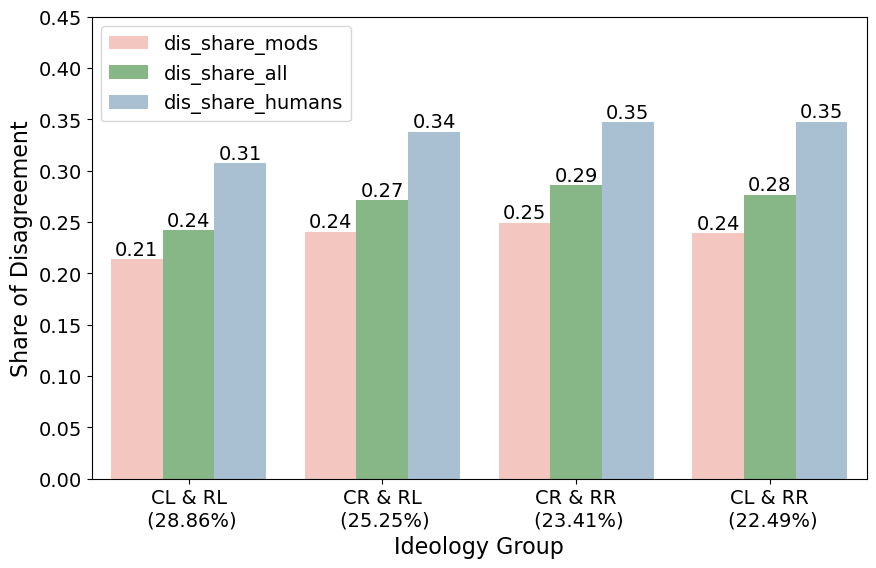

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the size here

xtick_label_map = {
    "CR & RR": "CR & RR\n (23.41%)",
    "CL & RL": "CL & RL\n (28.86%)",
    "CR & RL": "CR & RL\n (25.25%)",
    "CL & RR": "CL & RR\n (22.49%)"
}
color_dict = {"dis_share_mods": "salmon",
             "dis_share_humans" : "steelblue",
             "dis_share_all" : "green"}

sorted_order = (
    ideology_summary_plot[ideology_summary_plot["variable"] == "dis_share_humans"]
    .sort_values("value")["ideology_group"]
    .tolist()
) 

# Create barplot
sns.barplot(
    data=ideology_summary_plot,
    x="ideology_group",
    y="value",
    hue="variable",
    palette=color_dict,
    alpha=0.5,
    order=sorted_order,
    errorbar="sd",
    ax=ax
)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=14,
                color='black'
            )


new_labels = [xtick_label_map.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels, ha='center')
ax.tick_params(axis='both', labelsize=14)


# Set axis labels and title using matplotlib
ax.set_ylim(0, 0.45)
ax.set_xlabel("Ideology Group", fontsize=16)
ax.set_ylabel("Share of Disagreement", fontsize=16)

#ax.set_title("Disagreement Share by Ideology Group", fontsize=14)
ax.legend(title="", loc = "upper left", fontsize = 14)

plt.savefig("plots/Disagreement_Ideology_Type_Bars.pdf", bbox_inches='tight')





/tmp/ipykernel_327/723189130.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emi_plot_data_humans, x='emi_group', y='dis_share_humans', palette=bar_palette, ax=axes[0])
/tmp/ipykernel_327/723189130.py:20: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=emi_plot_data_humans, x='emi_group', y='dis_share_humans', palette=bar_palette, ax=axes[0])
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the 

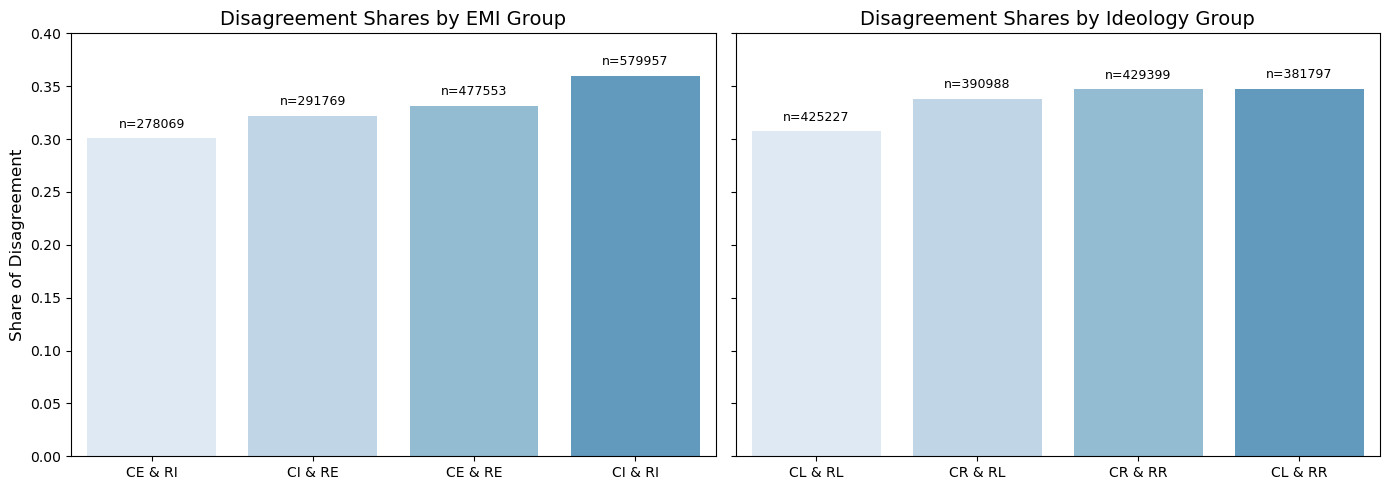

In [26]:
# Set color palette
bar_palette = sns.color_palette("Blues")

# Prepare data
emi_plot_data_humans = (
    emi_summary_humans[emi_summary_humans['emi_group'] != "Mixed/Neutral"]
    .sort_values('dis_share_humans', ascending=True)
    .reset_index(drop=True)
)
ideology_plot_data_humans = (
    ideology_summary_humans
    .sort_values('dis_share_humans', ascending=True)
    .reset_index(drop=True)
)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- EMI subplot ---
sns.barplot(data=emi_plot_data_humans, x='emi_group', y='dis_share_humans', palette=bar_palette, ax=axes[0])
axes[0].set_title('Disagreement Shares by EMI Group', fontsize = 14)
axes[0].set_ylabel('Share of Disagreement', fontsize = 12)
axes[0].set_xlabel('')
axes[0].set_ylim(0, 0.4)
axes[0].tick_params(axis='x')

# Annotate counts
for idx, row in emi_plot_data_humans.iterrows():
    axes[0].text(x=idx, y=row['dis_share_humans'] + 0.01, s=f"n={row['count']}", ha='center', fontsize=9)

# --- Ideology subplot ---
sns.barplot(data=ideology_plot_data_humans, x='ideology_group', y='dis_share_humans', palette=bar_palette, ax=axes[1])
axes[1].set_title('Disagreement Shares by Ideology Group', fontsize = 14)
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_ylim(0, 0.4)
axes[1].tick_params(axis='x')

# Annotate counts
for idx, row in ideology_plot_data_humans.iterrows():
    axes[1].text(x=idx, y=row['dis_share_humans'] + 0.01, s=f"n={row['count']}", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig("plots/Disagreement_Shares_EMI_Ideology_Bar.pdf")
plt.show()

## **Heatmaps**

In [22]:
heatmap_table_humans = (
    interactions
    .groupby(['emi_group', 'ideology_group'])
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))  # optional
    .reset_index()
)

# Pivot to matrix form
heatmap_table_humans 


heatmap_table_mods = (
    mod_interactions
    .groupby(['emi_group', 'ideology_group'])
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))  # optional
    .reset_index()
)

# Pivot to matrix form
heatmap_table_mods 

heatmap_table_all = (
    interactions_all
    .groupby(['emi_group', 'ideology_group'])
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))  # optional
    .reset_index()
)

# Pivot to matrix form
heatmap_table_all 

,emi_group,ideology_group,disagreement_share,count
0,CE & RE,CL & RL,0.221224,420989
1,CE & RE,CL & RR,0.252347,331401
2,CE & RE,CR & RL,0.244028,372699
3,CE & RE,CR & RR,0.258667,352190
4,CE & RI,CL & RL,0.214810,275336
5,CE & RI,CL & RR,0.251051,208328
6,CE & RI,CR & RL,0.244096,220114
7,CE & RI,CR & RR,0.262605,200796
8,CI & RE,CL & RL,0.234388,260419
9,CI & RE,CL & RR,0.264281,201407


In [23]:

share_data_humans = heatmap_table_humans[heatmap_table_humans['emi_group'] != "Mixed/Neutral"].pivot(
    index='emi_group', columns='ideology_group', values='disagreement_share')

count_data_humans = heatmap_table_humans[heatmap_table_humans['emi_group'] != "Mixed/Neutral"].pivot(
    index='emi_group', columns='ideology_group', values='count')


share_data_mods = heatmap_table_mods[heatmap_table_mods['emi_group'] != "Mixed/Neutral"].pivot(
    index='emi_group', columns='ideology_group', values='disagreement_share')

count_data_mods = heatmap_table_mods[heatmap_table_mods['emi_group'] != "Mixed/Neutral"].pivot(
    index='emi_group', columns='ideology_group', values='count')


share_data_all = heatmap_table_all[heatmap_table_all['emi_group'] != "Mixed/Neutral"].pivot(
    index='emi_group', columns='ideology_group', values='disagreement_share')

count_data_all = heatmap_table_all[heatmap_table_all['emi_group'] != "Mixed/Neutral"].pivot(
    index='emi_group', columns='ideology_group', values='count')

In [24]:
annot_data_human = share_data_humans.copy().astype(str)

for i in annot_data_human.index:
    for j in annot_data_human.columns:
        share = share_data_humans.loc[i, j]
        count = count_data_humans.loc[i, j]
        if pd.notna(share) and pd.notna(count):
            annot_data_human.loc[i, j] = f"{share:.2f}\n(#{int(count):,})"
        else:
            annot_data_human.loc[i, j] = ""



annot_data_mod = share_data_mods.copy().astype(str)

for i in annot_data_mod.index:
    for j in annot_data_mod.columns:
        share = share_data_mods.loc[i, j]
        count = count_data_mods.loc[i, j]
        if pd.notna(share) and pd.notna(count):
            annot_data_mod.loc[i, j] = f"{share:.2f}\n(#{int(count):,})"
        else:
            annot_data_mod.loc[i, j] = ""


annot_data_all = share_data_all.copy().astype(str)

for i in annot_data_all.index:
    for j in annot_data_all.columns:
        share = share_data_all.loc[i, j]
        count = count_data_all.loc[i, j]
        if pd.notna(share) and pd.notna(count):
            annot_data_all.loc[i, j] = f"{share:.2f}\n(#{int(count):,})"
        else:
            annot_data_all.loc[i, j] = ""



In [25]:
# reshape for plotting

heatmap_data_humans = heatmap_table_humans[heatmap_table_humans['emi_group'] != "Mixed/Neutral"].pivot(index='emi_group', columns='ideology_group', 
                                                                                                       values='disagreement_share')
heatmap_data_mods = heatmap_table_mods[heatmap_table_mods['emi_group'] != "Mixed/Neutral"].pivot(index='emi_group', columns='ideology_group', 
                                                                                                 values='disagreement_share')
heatmap_data_all = heatmap_table_all[heatmap_table_all['emi_group'] != "Mixed/Neutral"].pivot(index='emi_group', columns='ideology_group', 
                                                                                              values='disagreement_share')

* Col-wise means
    * disagreement shares are the lowest, if both are left leaning
    * and the highest if child is right leaning (PL&CR and PR&CR)
    * if a right leaning user is answering (to same or other, child = r), the disagreement probability is higher
* Row-wise means
    * disagreement is highest, when both are I speaking
    * lowest when parent E and child I $\to$ then, parent evidence child answers with new/different perspektive not disagreeing

## **Plotting, paper version**

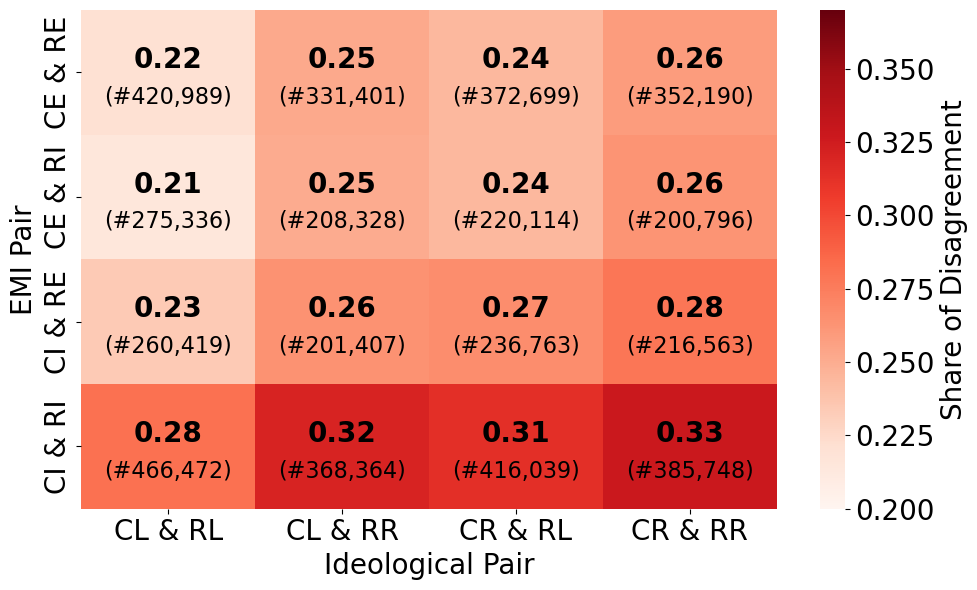

In [49]:
# All

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    share_data_all,
    annot=False, 
    cmap="Reds",
    cbar_kws={'label': 'Share of Disagreement'},
    vmin=0.2,
    vmax=0.37
)

# custom annotations
for y in range(share_data_all.shape[0]):
    for x in range(share_data_all.shape[1]):
        share = share_data_all.iloc[y, x]
        count = count_data_all.iloc[y, x]

        if pd.notna(share) and pd.notna(count):
            ax.text(
                x + 0.5, y + 0.4,
                f"{share:.2f}",
                ha='center', va='center',
                fontsize=20, fontweight='bold', color='black'
            )
            ax.text(
                x + 0.5, y + 0.7,
                f"(#{int(count):,})",
                ha='center', va='center',
                fontsize=16, color='black'
            )

# labels
plt.xlabel("Ideological Pair", fontsize=20)
plt.ylabel("EMI Pair", fontsize=20)
ax.tick_params(axis='both', labelsize=20)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)
colorbar.set_label('Share of Disagreement', fontsize=20)

plt.tight_layout()
plt.savefig("plots/Disagreement_Confusion_EMI_Ideology_all_Paper.pdf")
plt.show()

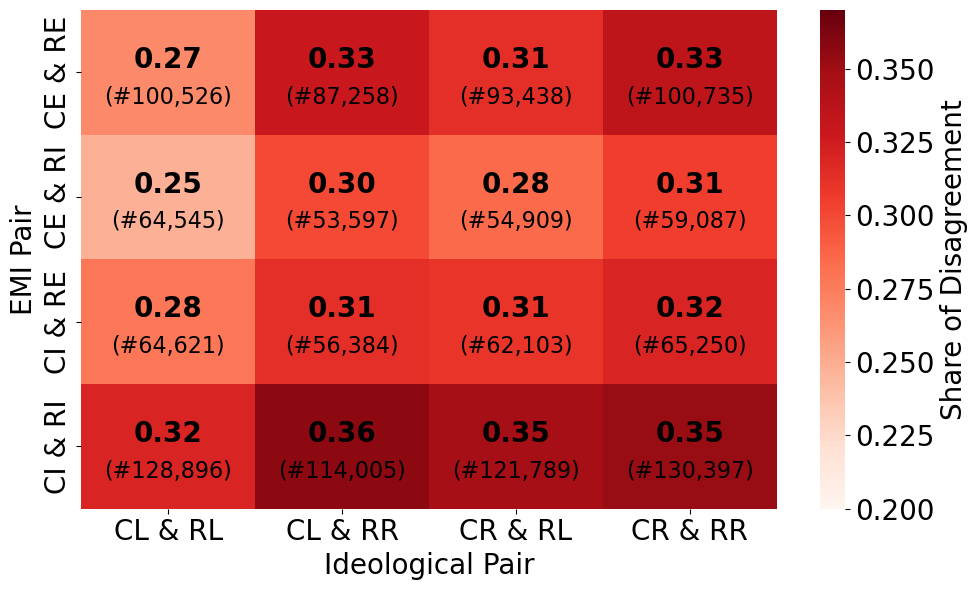

In [50]:
# humans

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    share_data_humans,
    annot=False, 
    cmap="Reds",
    cbar_kws={'label': 'Share of Disagreement'},
    vmin=0.2,
    vmax=0.37
)

# custom annotations
for y in range(share_data_humans.shape[0]):
    for x in range(share_data_humans.shape[1]):
        share = share_data_humans.iloc[y, x]
        count = count_data_humans.iloc[y, x]

        if pd.notna(share) and pd.notna(count):
            ax.text(
                x + 0.5, y + 0.4,
                f"{share:.2f}",
                ha='center', va='center',
                fontsize=20, fontweight='bold', color='black'
            )
            ax.text(
                x + 0.5, y + 0.7,
                f"(#{int(count):,})",
                ha='center', va='center',
                fontsize=16, color='black'
            )

# labels
plt.xlabel("Ideological Pair", fontsize=20)
plt.ylabel("EMI Pair", fontsize=20)
ax.tick_params(axis='both', labelsize=20)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)
colorbar.set_label('Share of Disagreement', fontsize=20)

plt.tight_layout()
plt.savefig("plots/Disagreement_Confusion_EMI_Ideology_humans_Paper.pdf")
plt.show()


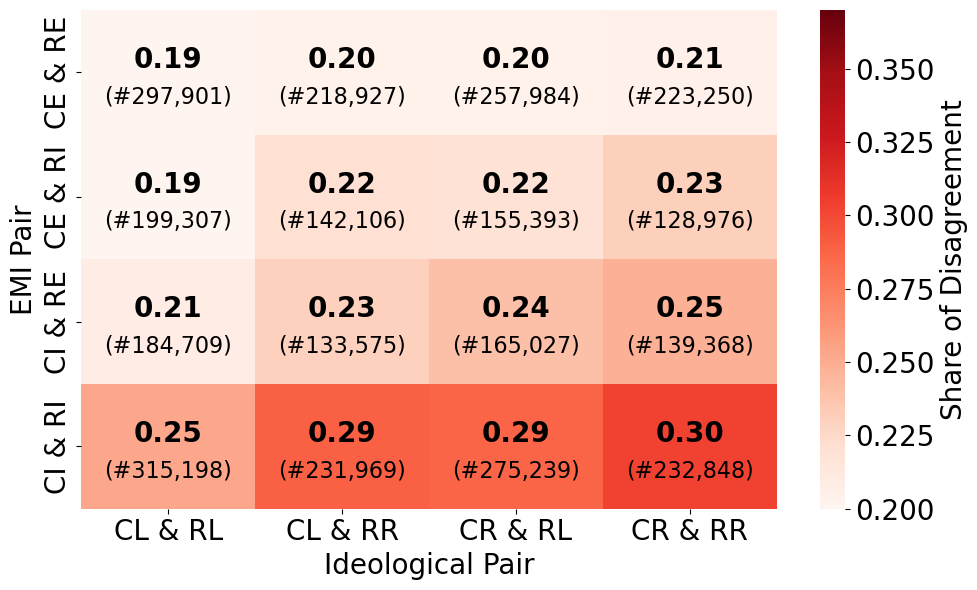

In [51]:
# mods

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    share_data_mods,
    annot=False, 
    cmap="Reds",
    cbar_kws={'label': 'Share of Disagreement'},
    vmin=0.2,
    vmax=0.37
)

# custom annotations
for y in range(share_data_mods.shape[0]):
    for x in range(share_data_mods.shape[1]):
        share = share_data_mods.iloc[y, x]
        count = count_data_mods.iloc[y, x]

        if pd.notna(share) and pd.notna(count):
            ax.text(
                x + 0.5, y + 0.4,
                f"{share:.2f}",
                ha='center', va='center',
                fontsize=20, fontweight='bold', color='black'
            )
            ax.text(
                x + 0.5, y + 0.7,
                f"(#{int(count):,})",
                ha='center', va='center',
                fontsize=16, color='black'
            )

# lables
plt.xlabel("Ideological Pair", fontsize=20)
plt.ylabel("EMI Pair", fontsize=20)
ax.tick_params(axis='both', labelsize=20)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)
colorbar.set_label('Share of Disagreement', fontsize=20)

plt.tight_layout()
plt.savefig("plots/Disagreement_Confusion_EMI_Ideology_mods_Paper.pdf")
plt.show()

***

# **20% most active humans**

In [35]:
activity_by_submission = interactions.groupby("submission_id").agg(
    activity = ("msg_id_parent", 'count')
).reset_index().sort_values(by = "activity", ascending = False).reset_index(drop = True)

cut_off = int(len(activity_by_submission)* 0.2)
print(cut_off)

active_submissions_humans = activity_by_submission.iloc[:cut_off]
active_submissions_humans

19752


,submission_id,activity
0,6g0srl,19941
1,9jcub5,16694
2,43ozro,12677
3,9jfa9a,9699
4,jn26hz,9450
...,...,...
19747,oulkck,12
19748,2becmo,12
19749,xjxqj,12
19750,3ssqvx,12


In [36]:

active_human_data = (
    interactions[interactions["submission_id"].isin(active_submissions_humans["submission_id"])]
    .groupby(['emi_group'])
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))  # optional
    .reset_index()
)
active_human_data

,emi_group,disagreement_share,count
0,CE & RE,0.310700,381957
1,CE & RI,0.283267,232138
2,CI & RE,0.305072,248358
3,CI & RI,0.344230,495087
4,Mixed/Neutral,0.148148,54


In [27]:
heatmap_table_humans_active = (
    interactions[interactions["submission_id"].isin(active_submissions_humans["submission_id"])]
    .groupby(['emi_group', 'ideology_group'])
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))  # optional
    .reset_index()
)

In [28]:

share_data_humans_active = heatmap_table_humans_active[heatmap_table_humans_active['emi_group'] != "Mixed/Neutral"].pivot(
    index='emi_group', columns='ideology_group', values='disagreement_share')

count_data_humans_active = heatmap_table_humans_active[heatmap_table_humans_active['emi_group'] != "Mixed/Neutral"].pivot(
    index='emi_group', columns='ideology_group', values='count')



annot_data_human_active = share_data_humans_active.copy().astype(str)

for i in annot_data_human_active.index:
    for j in annot_data_human_active.columns:
        share = share_data_humans_active.loc[i, j]
        count = count_data_humans_active.loc[i, j]
        if pd.notna(share) and pd.notna(count):
            annot_data_human_active.loc[i, j] = f"{share:.2f}\n(#{int(count):,})"
        else:
            annot_data_human_active.loc[i, j] = ""


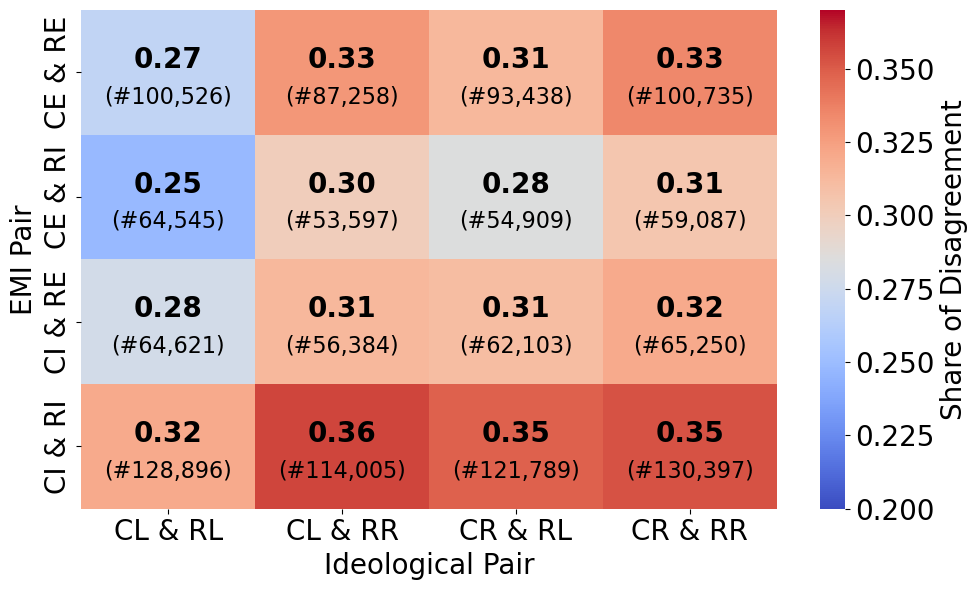

In [29]:
heatmap_table_humans_active = heatmap_table_humans_active[heatmap_table_humans_active['emi_group'] != "Mixed/Neutral"].pivot(index='emi_group', columns='ideology_group', values='disagreement_share')

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    share_data_humans_active,
    annot=False, 
    cmap="coolwarm",
    cbar_kws={'label': 'Share of Disagreement'},
    vmin=0.2,
    vmax=0.37
)

# custom annotations
for y in range(share_data_humans_active.shape[0]):
    for x in range(share_data_humans_active.shape[1]):
        share = share_data_humans_active.iloc[y, x]
        count = count_data_humans_active.iloc[y, x]

        if pd.notna(share) and pd.notna(count):
            ax.text(
                x + 0.5, y + 0.4,
                f"{share:.2f}",
                ha='center', va='center',
                fontsize=20, fontweight='bold', color='black'
            )
            ax.text(
                x + 0.5, y + 0.7,
                f"(#{int(count):,})",
                ha='center', va='center',
                fontsize=16, color='black'
            )

# labels
plt.xlabel("Ideological Pair", fontsize=20)
plt.ylabel("EMI Pair", fontsize=20)
ax.tick_params(axis='both', labelsize=20)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)
colorbar.set_label('Share of Disagreement', fontsize=20)

plt.tight_layout()
#plt.savefig("plots/Disagreement_Confusion_EMI_Ideology_humans_Paper.pdf")
plt.show()
